## Linear Regression
Linear model can be viewed as **single layer neural network**.

Optimal solution:
$w^* = (X^T X)^{-1} Xy$
![softmax-description](./imgs/3.png)


## Small Batch - Gradient Descent
在整个训练集上计算梯度太贵

我们可以随机采样b个样本，计算他们的平均损失

Batchsize is another important parameter

# Build Linear Regression From Scratch

## Build the dataset

In [54]:
%matplotlib inline 
import torch
import random

We generate a dataset:

$y = Xw+b+\sigma$ 

$w = [2,-3.4]^T, b= 4.2,\sigma$ is the noise term

In [55]:
def synthetic_data(w,b,num_examples):
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    return(X,y.reshape((-1,1))) # y.reshape((-1,1)) add one dimension
    #return(X,y)
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
features.shape,labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [56]:
print('Feature:',features[0],'Label:',labels[0])

Feature: tensor([0.6366, 2.1951]) Label: tensor([-1.9886])


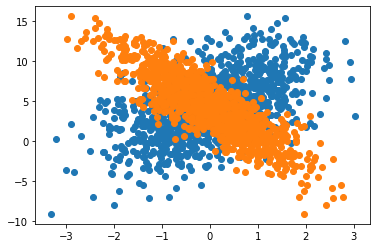

In [57]:
import matplotlib.pyplot as plt
# .detach() can be ignored sometimes
plt.scatter(features[:,0].detach().numpy(),labels[:,0].detach().numpy()) 
plt.scatter(features[:,1].detach().numpy(),labels[:,0].detach().numpy())

## Generate the training dataset
**Funtion:data_iter**
- input: batchsize,features,labels
- output: small batches

In [58]:
def data_iter(batch_size,features,labels):
    num_example = len(features)
    indices = torch.arange(num_example)
    random.shuffle(indices) # random
    for i in range(0,num_example,batch_size):
        batch_indices = indices[i:min(i+batch_size,num_example)]
        yield features[batch_indices,:],labels[batch_indices,:]
batch_size = 10
# print one batch
#for X,y in data_iter(batch_size,features,labels):
    #print(X,'\n',y)
    #break

In [59]:
w = torch.normal(0,1,size = (2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [8]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

In [9]:
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [31]:
# define a sgd
def sgd(params,lr,batch_size):
    with torch.no_grad(): # here we do not need to calculate the gradient
        for param in params:
            # loss sums up all the batchsize, that is why we  divide by batch_size here 
            param -=lr*param.grad/batch_size 
            param.grad.zero_()  # set grad to zero 

## Begin to Train
线性回归训练过程原理如下：
![train-principle](./imgs/2.png)

In [22]:
# rerun the cell will generate loss = Nan. Reason: w,b have not be initilaized
lr = 0.01
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) #size of l: (batch_size,1)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_1 = loss(net(features,w,b),labels)
        print('epoch:',epoch+1,'loss:',train_1.sum())
        print(f'epoch {epoch+1},loss {float(train_1.mean()):f}')

epoch: 1 loss: tensor(10.2155)
epoch 1,loss 0.010215
epoch: 2 loss: tensor(1.5236)
epoch 2,loss 0.001524
epoch: 3 loss: tensor(0.3002)
epoch 3,loss 0.000300


# Build Linear Regression using torch.nn

In [60]:
import torch.nn as nn
from torch.utils import data
import numpy as np

In [63]:
net = nn.Sequential(nn.Linear(2,1))
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

trainer = torch.optim.SGD(net.parameters(),lr = 0.03)

In [64]:
def load_array(data_arrays,batch_size,is_train = True):
    dataset= data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)
data_iter = load_array((features,labels),batch_size)

In [76]:
lr = 0.00001
num_epochs = 3
batch_size = 10
loss = nn.MSELoss()
for epoch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X),y) #size of l: (batch_size,1)
        
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.000107
epoch 2, loss 0.000106
epoch 3, loss 0.000108
